# Correlation regarding the Children to Teachers Ratio

In [1]:
from school_analysis.preprocessing.load import Loader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb
import school_analysis as sa
from school_analysis.plotting.general import GeneralPlots
from school_analysis.preprocessing import SCHOOL_TYPE_MAPPING

loader = Loader()

# Budgets
budget = loader.load("budgets-corrected")

# Grades
grades = loader.load("abi-grades")
grades_temp = grades.T.reset_index().rename(columns={"level_0": "Federal State", "level_1": "Year"})
grades = pd.melt(grades_temp, id_vars=["Federal State", "Year"], value_vars=grades_temp.columns[2:], value_name="Value")
grades["Federal State"] = grades["Federal State"].map(sa.STATE_MAPPING)
grades["Year"] = grades["Year"].astype(int)
grades["Grade"] = grades["Grade"].astype(float)

# Repeaters
repeaters = loader.load("number_of_repeaters")
repeaters = repeaters.rename(columns={"state": "Federal State", "school": "School Type", "year": "Year", "total": "Repeaters", "grade": "Grade"}).drop(columns=["male", "female"])
repeaters["Repeaters"] = repeaters["Repeaters"].replace("-", np.nan).dropna().astype(int)

# Teachers to Students
teachers_students_state = loader.load("students-per-teacher-by-state")
teachers_students_state = teachers_students_state.dropna().drop_duplicates()
teachers_students_type = loader.load("students-per-teacher-by-type")
teachers_students_type = teachers_students_type.dropna().drop_duplicates()


In [2]:
teachers_students_state.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3057 entries, 0 to 3104
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Federal State         3057 non-null   object 
 1   Type                  3057 non-null   object 
 2   Year                  3057 non-null   int64  
 3   Students per Teacher  3057 non-null   float64
 4   Sum Teachers          3057 non-null   float64
 5   Contract Type         3057 non-null   object 
 6   Students              3057 non-null   float64
 7   Number of Teachers    3057 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 214.9+ KB


## Teachers to Students Ratio vs. Grades

In [3]:
# Get data
ts_state_c = teachers_students_state.copy()
ts_type_c = teachers_students_type.copy()
grades_c = grades.copy()

# Filter the data to only required cols
ts_state_c = ts_state_c[ts_state_c["Type"] == "Pupils"][["Federal State", "Year", "Students per Teacher"]].drop_duplicates()
ts_state_avg = ts_state_c.groupby(["Year"]).apply(lambda x: x["Students per Teacher"].mean()).reset_index().rename(columns={0: "Students per Teacher"})

grades_c["Grade"] = grades_c["Grade"]
avg_grade_state = grades_c.groupby(["Federal State", "Year"]).apply(lambda x: (x["Grade"] * x["Value"]).sum() / x["Value"].sum()).reset_index().rename(columns={0: "Average Grade"})
avg_grade = grades_c.groupby(["Year"]).apply(lambda x: (x["Grade"] * x["Value"]).sum() / x["Value"].sum()).reset_index().rename(columns={0: "Average Grade"})


In [4]:
grade_ts_state = pd.merge(ts_state_c, avg_grade_state, on=["Federal State", "Year"])
grade_ts_state_avg = pd.merge(ts_state_avg, avg_grade, on=["Year"])

print("Corr [TS, Grade] by State: ", np.corrcoef(grade_ts_state["Students per Teacher"], grade_ts_state["Average Grade"])[0][1])
print("Corr [TS, Grade] by Avg over all States: ", np.corrcoef(grade_ts_state_avg["Students per Teacher"], grade_ts_state_avg["Average Grade"])[0][1])

Corr [TS, Grade] by State:  0.3555832254922999
Corr [TS, Grade] by Avg over all States:  0.9015207901020657


In [5]:
grade_ts_state_avg

,Year,Students per Teacher,Average Grade
0,2007,11.876377,2.530665
1,2008,11.674574,2.523515
2,2009,11.421269,2.517675
3,2010,11.303607,2.500708
4,2011,11.329358,2.498626
5,2012,11.326305,2.472224
6,2013,11.342102,2.459223
7,2014,11.320906,2.456677
8,2015,11.252558,2.454814
9,2016,11.220105,2.435339


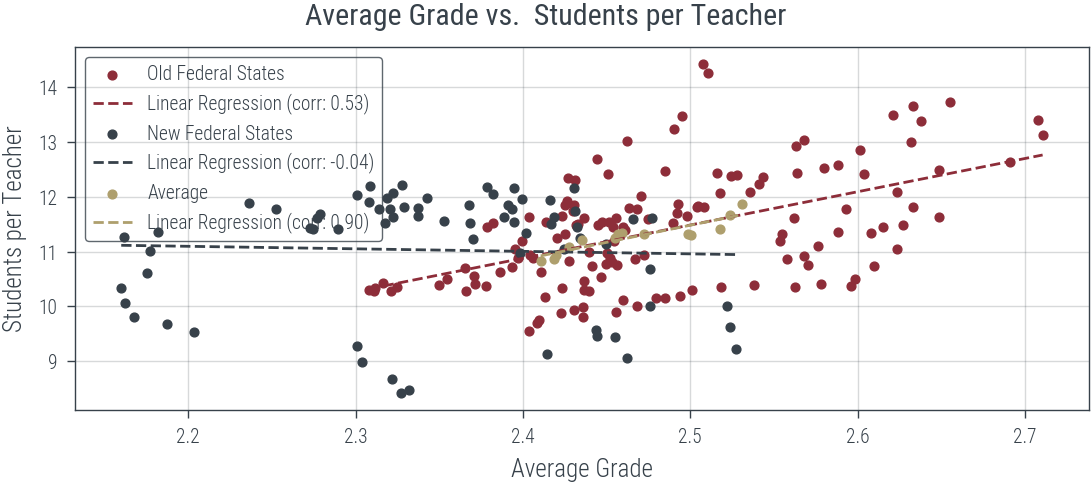

In [6]:
GeneralPlots.federal_state_corr_plot(
    grade_ts_state,
    "Students per Teacher",
    "Average Grade",
    melted_df=grade_ts_state_avg,
)

## Correlation between the teachers to students ratio and the budget per student

In [7]:
# Get data
ts_state_c = teachers_students_state.copy()
ts_type_c = teachers_students_type.copy()
budget_c = budget.copy()

# Filter the data to only required cols
ts_state_c = ts_state_c[ts_state_c["Type"] == "Pupils"][["Federal State", "Year", "Students per Teacher"]].drop_duplicates()
ts_state_avg = ts_state_c.groupby(["Year"]).apply(lambda x: x["Students per Teacher"].mean()).reset_index().rename(columns={0: "Students per Teacher"})

budget_c = budget_c.drop(columns=["Year Relative", "Index"])
budget_c_avg = budget_c.groupby(["Year"]).apply(lambda x: x["Reference Budget"].mean()).reset_index().rename(columns={0: "Reference Budget"})


In [8]:
ts_budget_state = pd.merge(ts_state_c, budget_c, on=["Federal State", "Year"]).dropna().drop_duplicates()
ts_budget_state_avg = pd.merge(ts_state_avg, budget_c_avg, on=["Year"]).dropna().drop_duplicates()

print("Corr [TS, Budget] by State: ", np.corrcoef(ts_budget_state["Students per Teacher"], ts_budget_state["Reference Budget"])[0][1])
print("Corr [TS, Budget] by Avg over all States: ", np.corrcoef(ts_budget_state_avg["Students per Teacher"], ts_budget_state_avg["Reference Budget"])[0][1])


Corr [TS, Budget] by State:  -0.4880290070018399
Corr [TS, Budget] by Avg over all States:  -0.9580021395168237


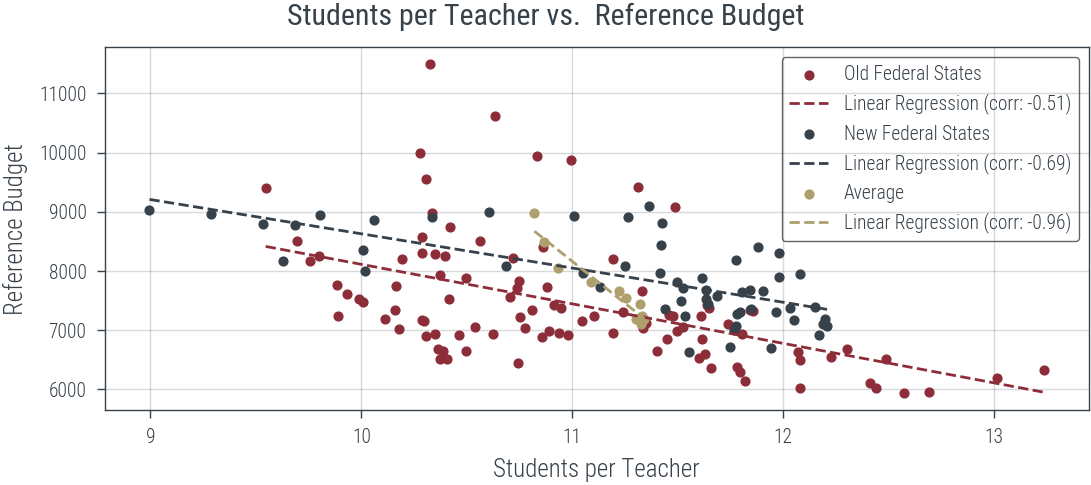

In [9]:
GeneralPlots.federal_state_corr_plot(
    ts_budget_state,
    "Reference Budget",
    "Students per Teacher",
    melted_df=ts_budget_state_avg,
)

## Correlation between the teachers to students ratio and the repeater rate

In [10]:
# Get data
ts_state_c = teachers_students_state.copy()
ts_type_c = teachers_students_type.copy()
repeaters_c = repeaters.copy()

# Filter the data to only required cols
ts_state_c = ts_state_c[ts_state_c["Type"] == "Pupils"][["Federal State", "Year", "Students per Teacher"]].drop_duplicates()
ts_state_avg = ts_state_c.groupby(["Year"]).apply(lambda x: x["Students per Teacher"].mean()).reset_index().rename(columns={0: "Students per Teacher"})

repeaters_state = repeaters_c.groupby(["Federal State", "Year"]).apply(lambda x: x["Repeaters"].mean()).reset_index().rename(columns={0: "Repeaters"})
repeaters_avg = repeaters_c.groupby(["Year"]).apply(lambda x: x["Repeaters"].mean()).reset_index().rename(columns={0: "Repeaters"})

In [11]:
ts_repeaters_state = pd.merge(ts_state_c, repeaters_state, on=["Federal State", "Year"]).dropna().drop_duplicates()
ts_repeaters_state_avg = pd.merge(ts_state_avg, repeaters_avg, on=["Year"]).dropna().drop_duplicates()

print("Corr [TS, Repeaters] by State: ", np.corrcoef(ts_repeaters_state["Students per Teacher"], ts_repeaters_state["Repeaters"])[0][1])
print("Corr [TS, Repeaters] by Avg over all States: ", np.corrcoef(ts_repeaters_state_avg["Students per Teacher"], ts_repeaters_state_avg["Repeaters"])[0][1])

Corr [TS, Repeaters] by State:  0.5239656038909543
Corr [TS, Repeaters] by Avg over all States:  0.9595752257303714


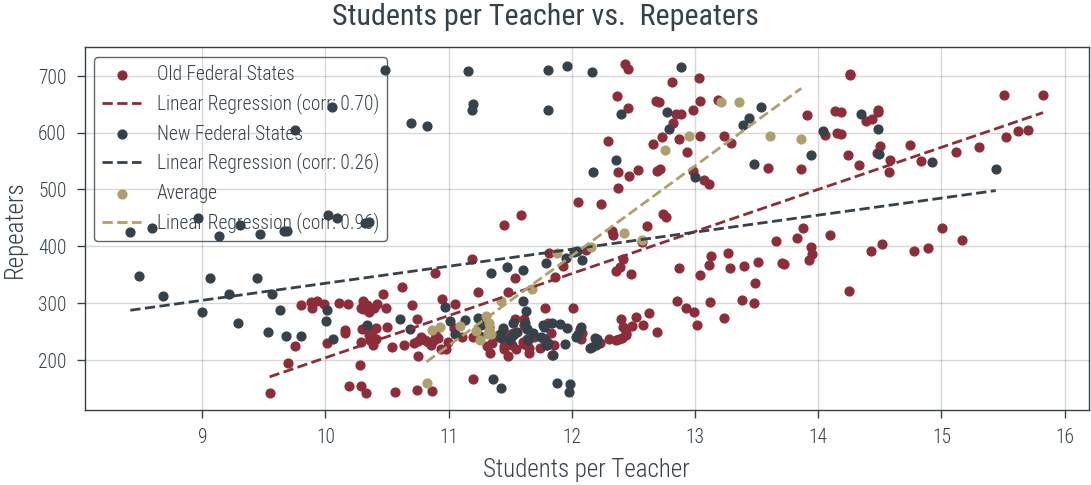

In [12]:
GeneralPlots.federal_state_corr_plot(
    ts_repeaters_state,
    "Repeaters",
    "Students per Teacher",
    melted_df=ts_repeaters_state_avg,
)

## Correlation between the teachers to students ratio and the repeater by school type

In [13]:
# Get data
ts_type_c = teachers_students_type.copy()
repeaters_c = repeaters.copy()
repeaters_c["School Type"] = repeaters_c["School Type"].map(SCHOOL_TYPE_MAPPING)
repeaters_c = repeaters_c.dropna().drop_duplicates()

# Filter the data to only required cols
ts_type_c = ts_type_c[["School Type", "Year", "Students per Teacher"]].drop_duplicates()
ts_type_avg = ts_type_c.groupby(["Year"]).apply(lambda x: x["Students per Teacher"].mean()).reset_index().rename(columns={0: "Students per Teacher"})

repeaters_type = repeaters_c.groupby(["School Type", "Year"]).apply(lambda x: x["Repeaters"].mean()).reset_index().rename(columns={0: "Repeaters"})
repeaters_avg = repeaters_c.groupby(["Year"]).apply(lambda x: x["Repeaters"].mean()).reset_index().rename(columns={0: "Repeaters"})

In [14]:
ts_repeaters_type = pd.merge(ts_type_c, repeaters_type, on=["School Type", "Year"]).dropna().drop_duplicates()
ts_repeaters_type_avg = pd.merge(ts_type_avg, repeaters_avg, on=["Year"]).dropna().drop_duplicates()

print("Corr [TS, Repeaters] by Type: ", np.corrcoef(ts_repeaters_type["Students per Teacher"], ts_repeaters_type["Repeaters"])[0][1])
print("Corr [TS, Repeaters] by Avg over all Types: ", np.corrcoef(ts_repeaters_type_avg["Students per Teacher"], ts_repeaters_type_avg["Repeaters"])[0][1])

Corr [TS, Repeaters] by Type:  0.8239939016508683
Corr [TS, Repeaters] by Avg over all Types:  0.05277072015041847


/home/tomf/.cache/pypoetry/virtualenvs/school-analysis-Zuc5u-dz-py3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tomf/.cache/pypoetry/virtualenvs/school-analysis-Zuc5u-dz-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/tomf/.cache/pypoetry/virtualenvs/school-analysis-Zuc5u-dz-py3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/tomf/.cache/pypoetry/virtualenvs/school-analysis-Zuc5u-dz-py3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/tomf/.cache/pypoetry/virtualenvs/school-analysis-Zuc5u-dz-py3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: inval

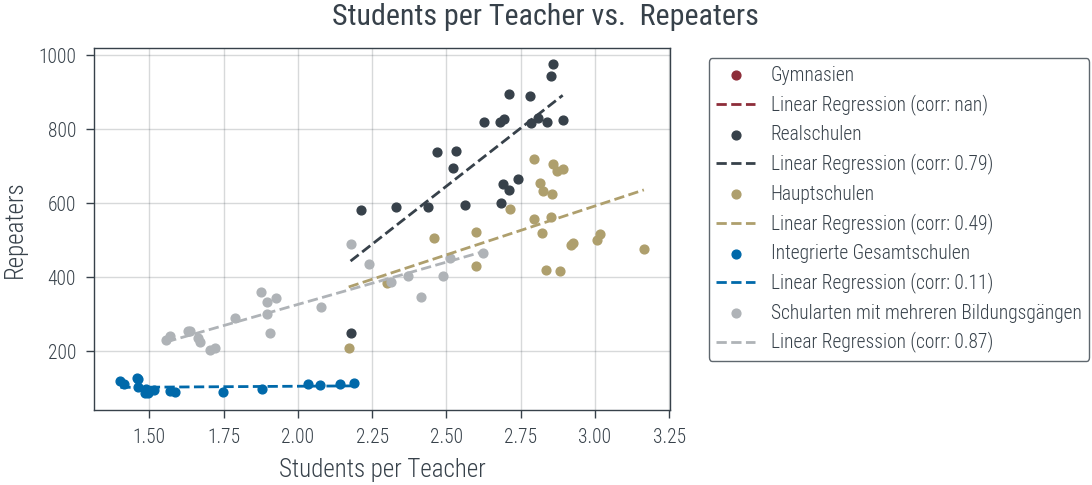

In [15]:
from school_analysis.preprocessing.helpers.students_teachers import get_most_common_school_types


GeneralPlots.school_type_corr_plot(
    ts_repeaters_type,
    "Repeaters",
    "Students per Teacher",
    # melted_df=ts_repeaters_type_avg,
    school_types=get_most_common_school_types(teachers_students_type, 5, school_type_col="School Type", value_col="Students"),
    avg=False
)    


In [16]:
ts_repeaters_type["School Type"].unique()

array(['Hauptschulen', 'Integrierte Gesamtschulen', 'Realschulen',
       'Schularten mit mehreren Bildungsgängen'], dtype=object)